# Bayesian Ridge Regression - Technical Indicators

# References 

* http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information matplotlib, numpy, pandas, pymc3, seaborn, sklearn

Software versions
Python 3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 3.13.0 86 generic x86_64 with debian jessie sid
matplotlib 1.5.1
numpy 1.10.4
pandas 0.18.0
pymc3 3.0
seaborn 0.7.0
sklearn 0.17.1
Fri May 20 04:05:45 2016 BST

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import preprocessing as preproc
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae

np.set_printoptions(threshold=np.nan)
sns.set()

In [56]:
path = '../btc-data/BTC_LOB_techind_10s.csv'
data10s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_30s.csv'
data30s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_60s.csv'
data1m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_300s.csv'
data5m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_600s.csv'
data10m = pd.read_csv(path, index_col = 0, parse_dates = True)

datas = [data10s, data30s, data1m, data5m, data10m]

# Data Preprocessing

In [68]:
def evaluate(data):
    
    X, y = data, data['DELTAP'].copy()

    for df in X.columns.tolist():
        X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))
        
    train_dates = X.index[:int(0.7*len(X))]
    test_dates = X.index[int(0.7*len(X)):]

    #X_train[train_dates[0] : train_dates[-361]] = [X[i : i + 360] for i in range(len(X[:-360]))]
    #X_test = X[test_dates[0] : test_dates[-361]]
    #y_train = y[train_dates[360] : train_dates[-1]]
    #y_test = y[test_dates[360] : test_dates[-361]]

    print('First training date: ', train_dates[0])
    print('Last training date: ', train_dates[-1])
    print('First testing date: ', test_dates[0])
    print('Last testing date: ', test_dates[-1])

    # Create DataFrames for the training set. Input: mid prices from the previous hour, output: mid price change in the next 10 seconds.

    X_train = X[train_dates[0]:].drop(['mid price', 'DELTAP'], axis = 1)
    y_train = y[train_dates[0]:]

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plt.title("Weights of the previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Prices")
    plt.ylabel("Weights")

    X_test = X[test_dates[0]:].drop(['mid price', 'DELTAP'], axis = 1)
    y_test = y[test_dates[0]:]

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates)

    plt.figure(figsize = (20,10))
    plt.title('Prediction with previous 360 prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.legend()

    plt.figure(figsize = (20,10))
    plt.title('Zoom in')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-24 00', '2016-04-25 00')
    plt.legend()
    
    print('\n\nResults of prediction with previous 360 prices')
    print('==============================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('==============================================\n\n')
    
    print(clf.scores_)

    '''for c in X.drop('mid price', axis = 1).columns.tolist():
        for i in range(2):
            colname = c + ' ' + str(i + 1)
            X_train[colname] = X[c].ix[358 + i : len(train_dates) + i - 2].values

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20,10))
    plt.title("Weights of the features and previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Features")
    plt.xlim(350, 383)
    plt.ylabel("Weights")

    for c in X.drop('mid price', axis = 1).columns.tolist():
        for i in range(2):
            colname = c + ' ' + str(i + 1)
            X_test[colname] = X[c].ix[len(train_dates) + 358 + i : len(train_dates) + len(test_dates) + i - 2].values

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates[360:])

    plt.figure(figsize = (20,10))
    plt.title('Prediction with features and prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-08 19', '2016-04-08 20')
    plt.ylim(416.3, 424.1)
    plt.legend()

    print('Results of prediction with previous 360 prices and previous 2 features')
    print('======================================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('======================================================================\n\n')

    X_train = pd.DataFrame()
    y_train = y[train_dates[2] : train_dates[-1]]
    
    for i in range(2):
        colname = 'mid price ' + str(i + 1)
        X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 2)].values
    
    for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
        X_train[c] = X[c].ix[1 : len(train_dates) - 1].values
    
    X_train.set_index(train_dates[2:], inplace = True)

    X_test = pd.DataFrame()
    y_test = y[test_dates[2] : test_dates[-1]]

    for i in range(2):
        colname = 'mid price ' + str(i + 1)
        X_test[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(test_dates) + i - 2)].values
    
    for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
        X_test[c] = X[c].ix[len(train_dates) + 1 : len(train_dates) + len(test_dates) - 1].values
            
    X_test.set_index(test_dates[2:], inplace = True)

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates[2:])

    print('Results of prediction with previous 2 prices and selected features')
    print('=========================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('=========================================================\n\n')'''

First training date:  2016-01-01 02:59:40
Last training date:  2016-03-25 18:23:40
First testing date:  2016-03-25 18:23:50
Last testing date:  2016-05-01 00:59:50


Results of prediction with previous 360 prices

Training set R2:  0.0118093334661 , Test set R2:  0.00800991064697
Training set RMSE:  0.119453960271 , Test set RMSE:  0.0934397511973
Training set MAE:  0.0403975626299 , Test set MAE:  0.0281487241468
Directional Symmetry:  0.599181279833 



0.154914986315
0.000101717520109
[737781.7214085157, 737802.15504085924, 737803.26551984029, 737803.37475726905]


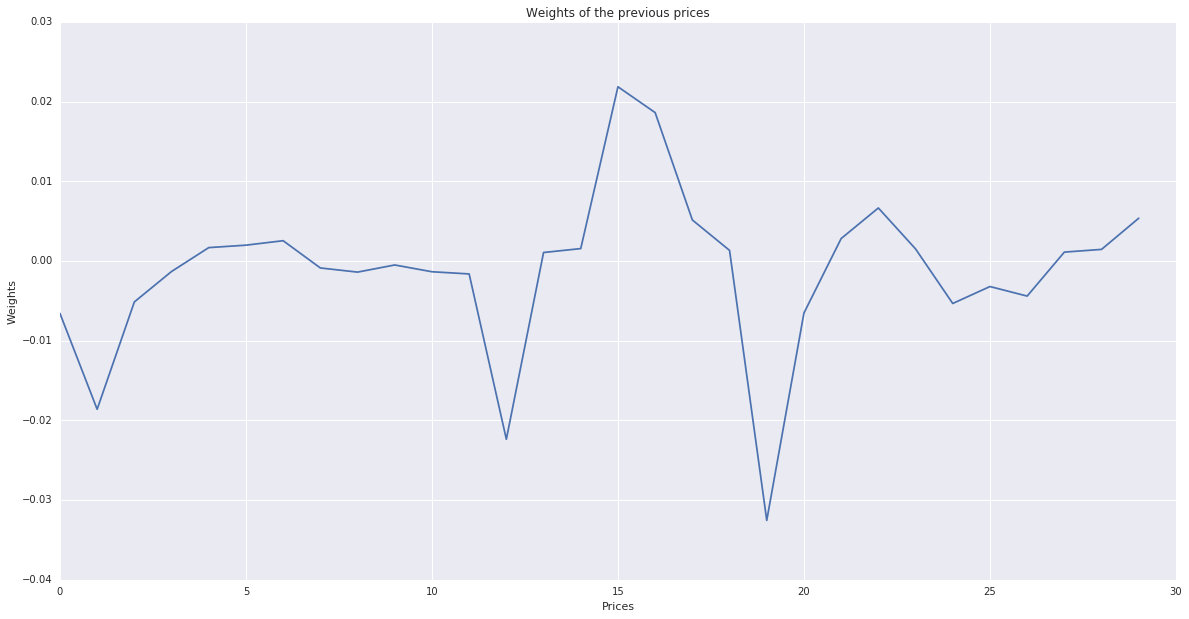

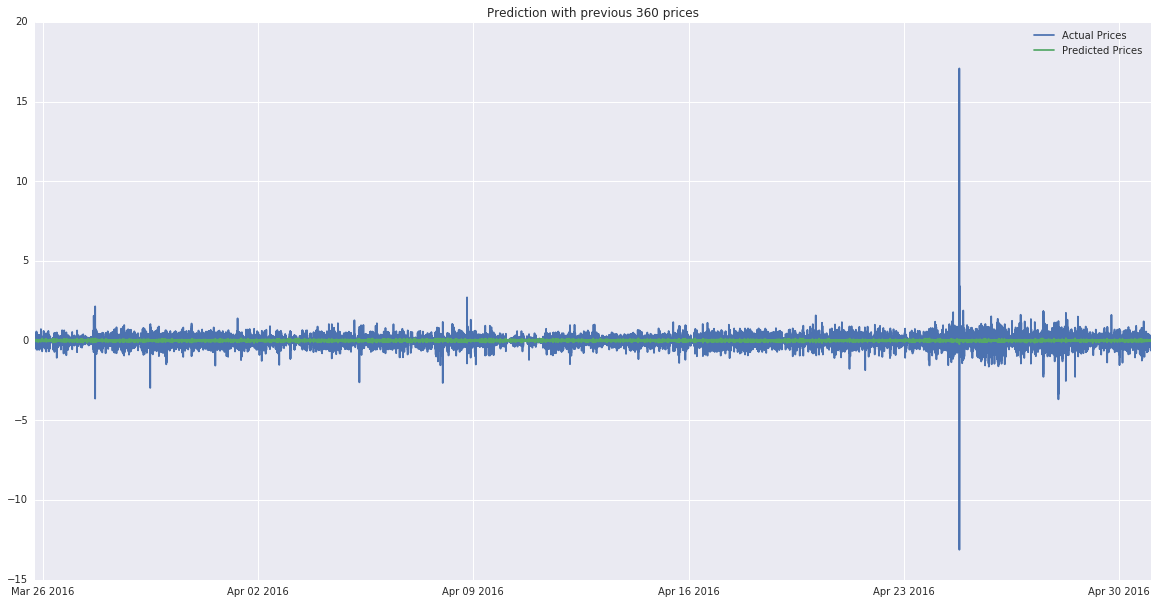

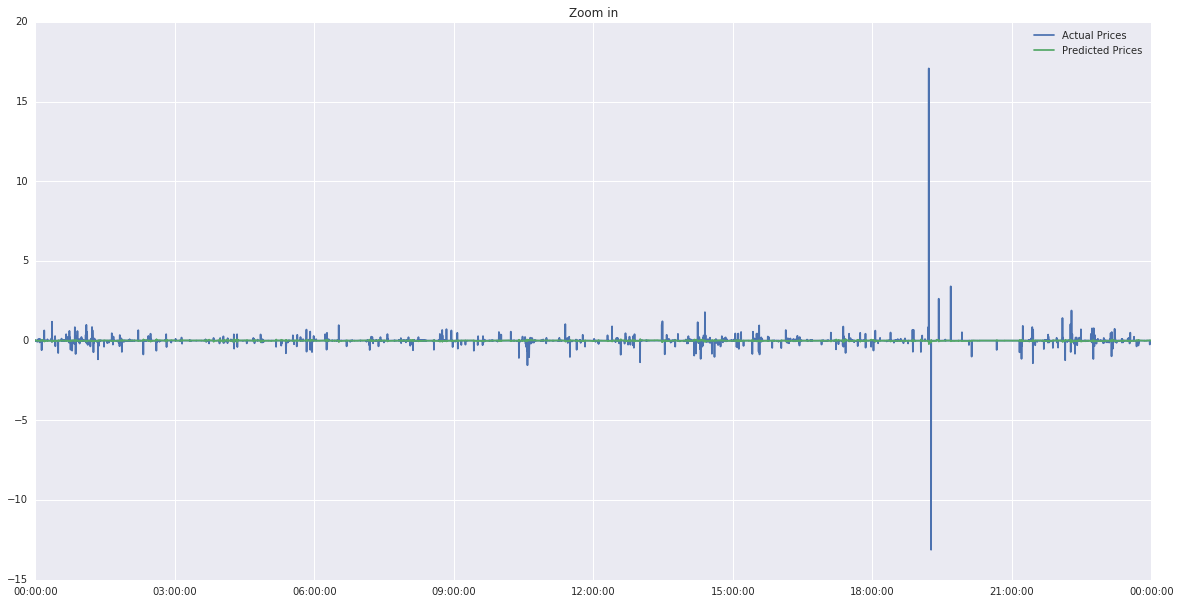

In [69]:
evaluate(datas[0].copy())

First training date:  2016-01-01 08:59:00
Last training date:  2016-03-25 20:11:00
First testing date:  2016-03-25 20:11:30
Last testing date:  2016-05-01 00:59:30


Results of prediction with previous 360 prices

Training set R2:  0.0168519702231 , Test set R2:  0.00587806396273
Training set RMSE:  0.193257414361 , Test set RMSE:  0.153398180244
Training set MAE:  0.0848325318786 , Test set MAE:  0.0606330883735
Directional Symmetry:  0.635042587477 



0.223622382247
0.000303480821432


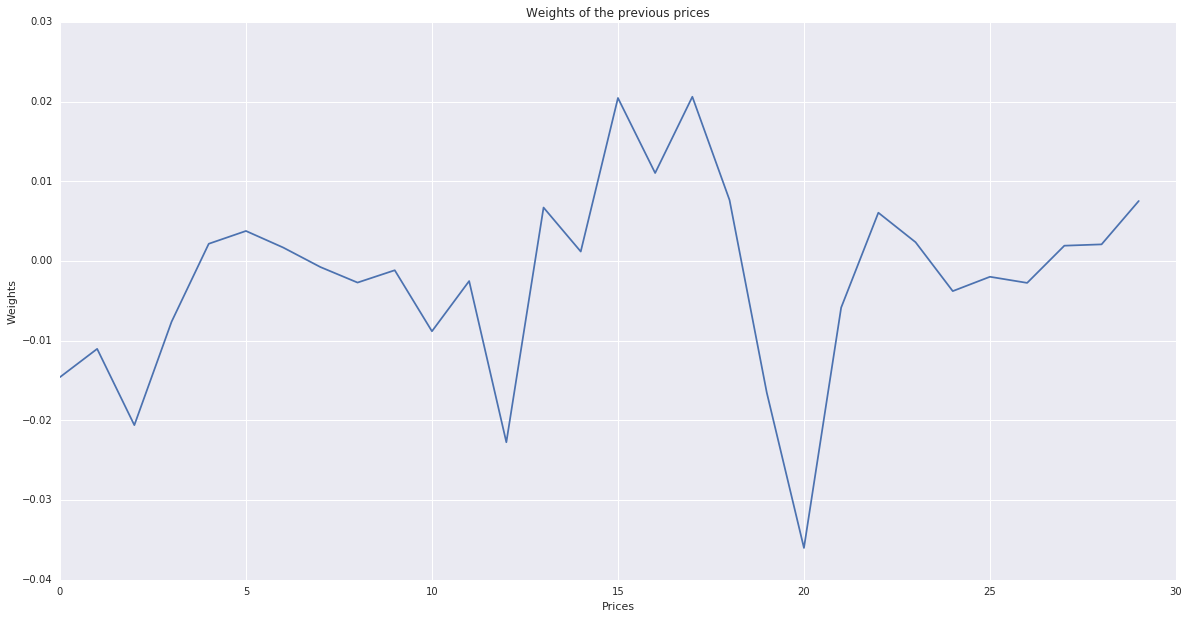

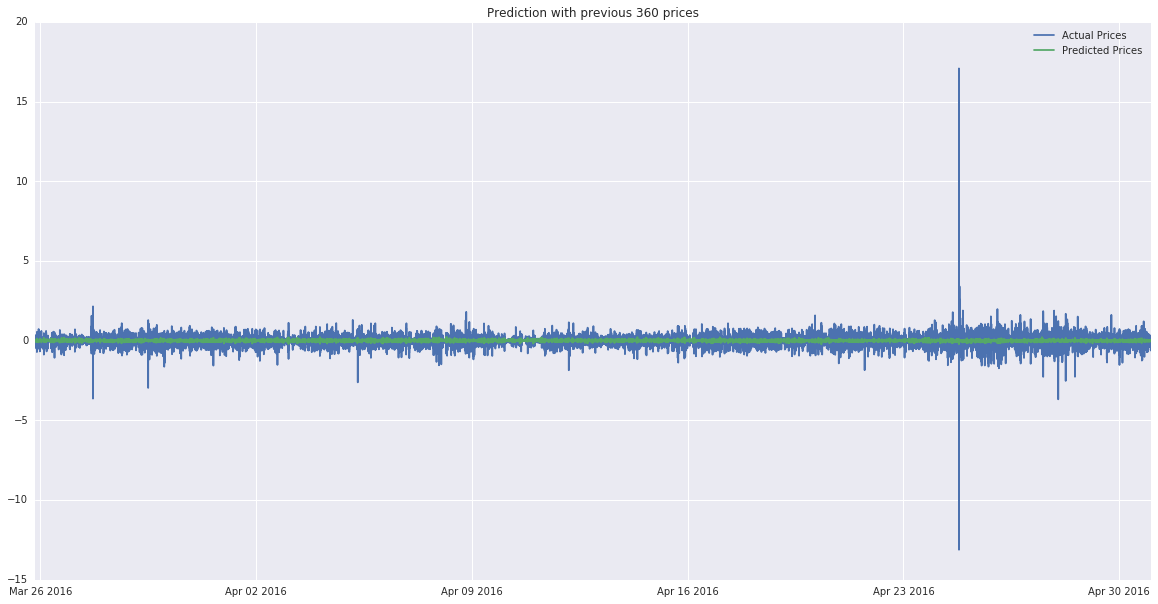

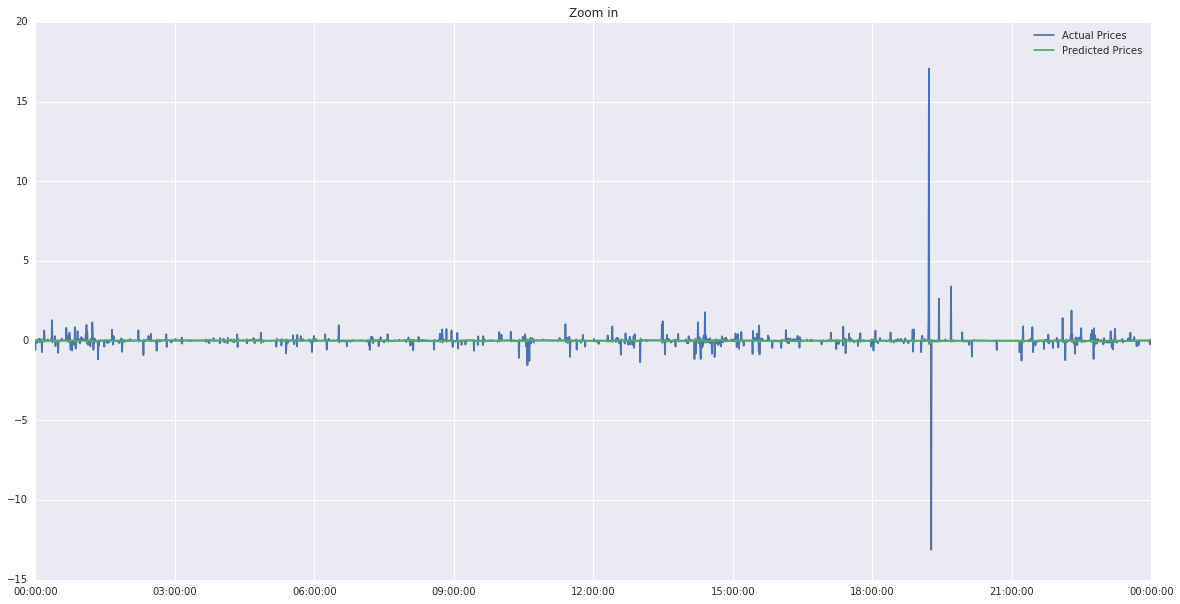

In [59]:
evaluate(datas[1].copy())

First training date:  2016-01-01 17:58:00
Last training date:  2016-03-25 22:52:00
First testing date:  2016-03-25 22:53:00
Last testing date:  2016-05-01 00:59:00


Results of prediction with previous 360 prices

Training set R2:  0.014756163947 , Test set R2:  0.00953100494227
Training set RMSE:  0.25908939674 , Test set RMSE:  0.210505848686
Training set MAE:  0.126672461759 , Test set MAE:  0.0923289488943
Directional Symmetry:  0.652407343263 



0.200286145288
0.00059855292782


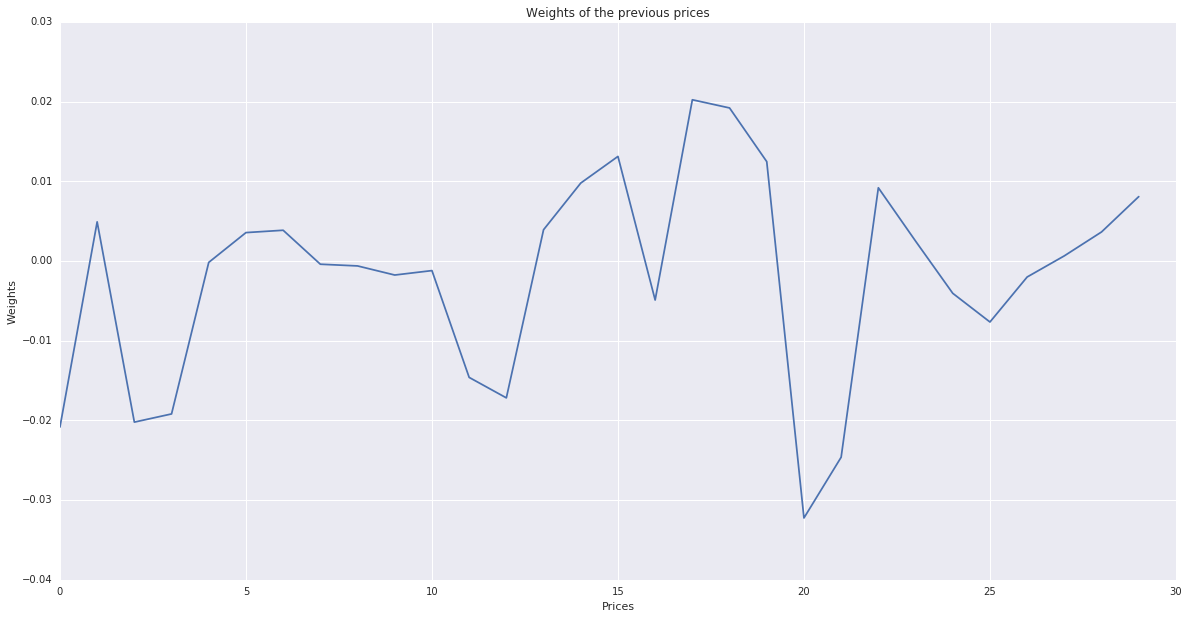

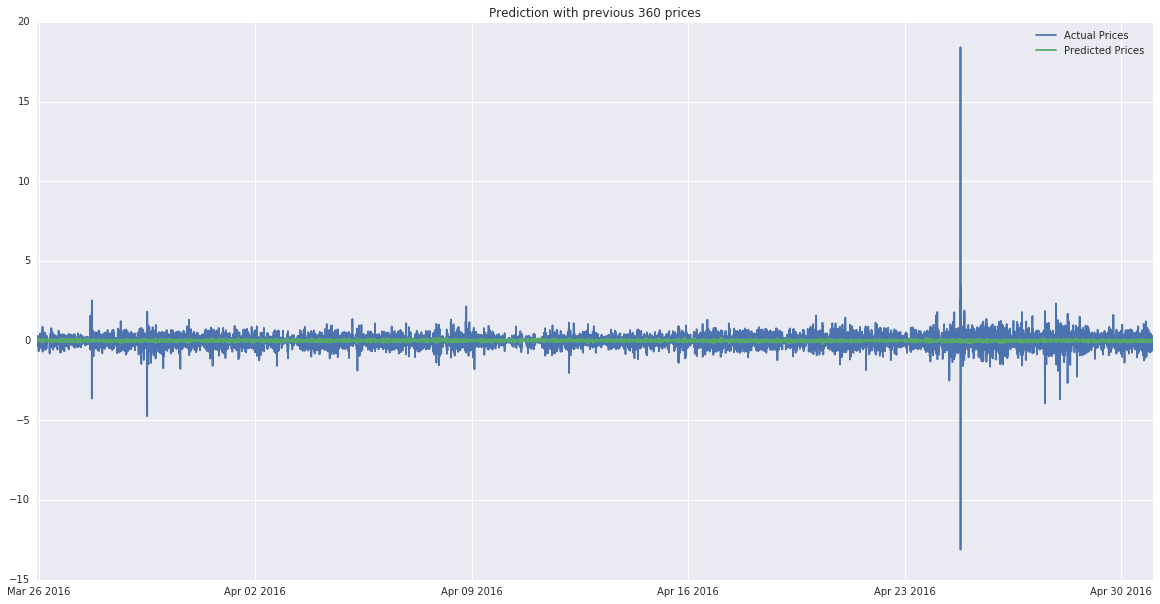

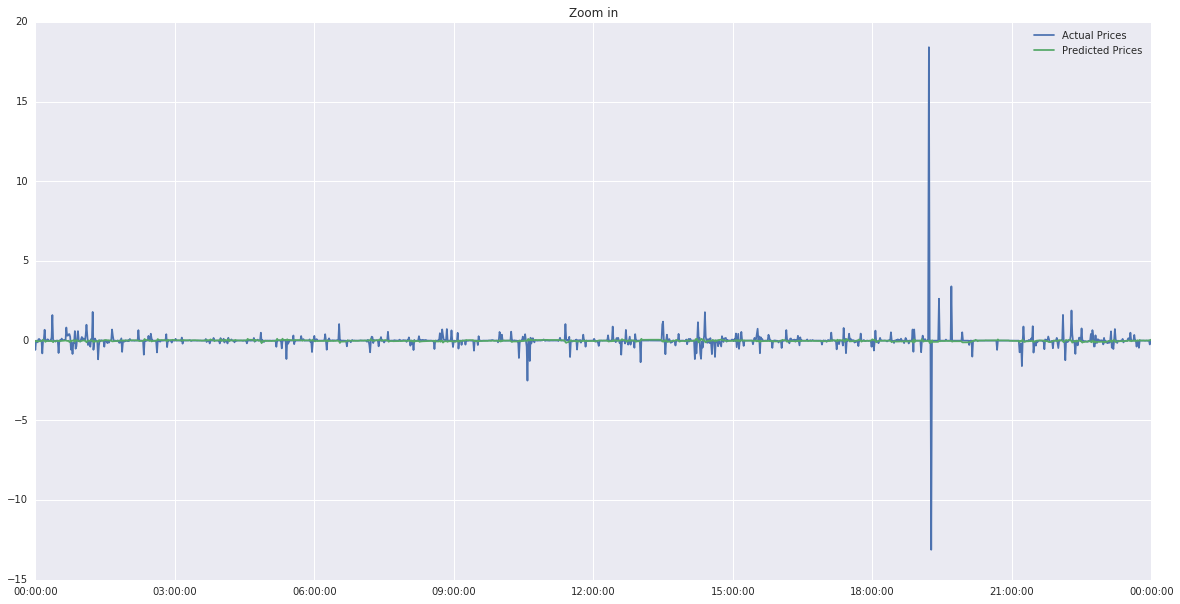

In [60]:
evaluate(datas[2].copy())

First training date:  2016-01-04 17:50:00
Last training date:  2016-03-26 20:20:00
First testing date:  2016-03-26 20:25:00
Last testing date:  2016-05-01 00:55:00


Results of prediction with previous 360 prices

Training set R2:  0.011998030054 , Test set R2:  0.0168483333498
Training set RMSE:  0.552615588805 , Test set RMSE:  0.447946646399
Training set MAE:  0.306653147769 , Test set MAE:  0.230258841397
Directional Symmetry:  0.666962699822 



0.341603497554
0.00313418845585


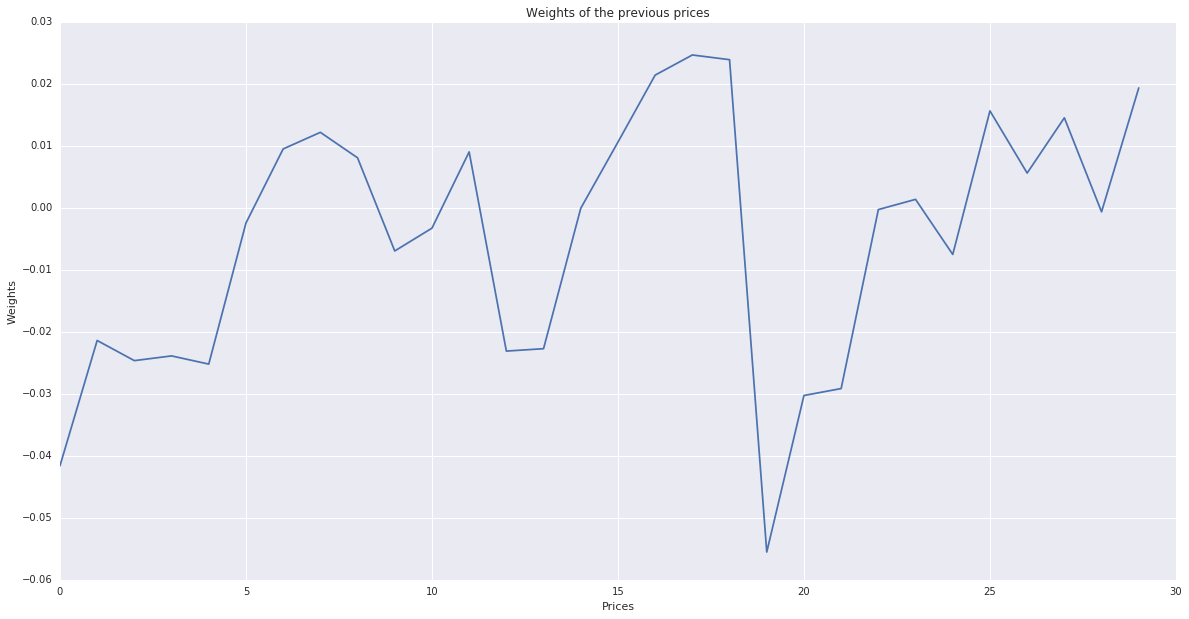

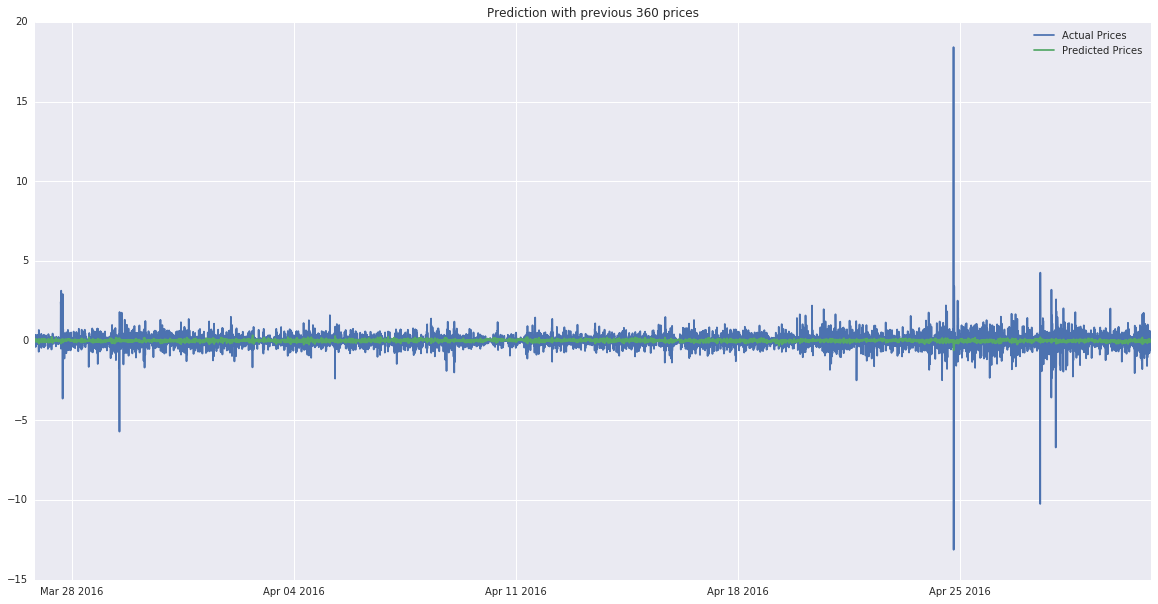

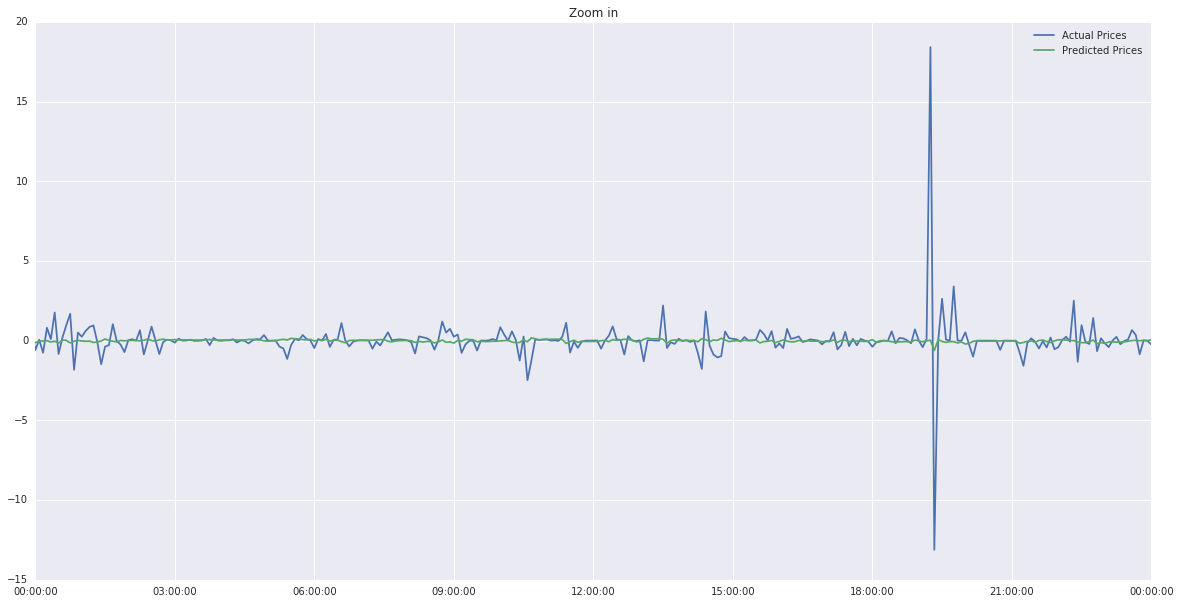

In [61]:
evaluate(datas[3].copy())

First training date:  2016-01-08 11:40:00
Last training date:  2016-03-27 23:10:00
First testing date:  2016-03-27 23:20:00
Last testing date:  2016-05-01 00:50:00


Results of prediction with previous 360 prices

Training set R2:  0.0118593497773 , Test set R2:  0.00678968970782
Training set RMSE:  0.745060964183 , Test set RMSE:  0.532660398906
Training set MAE:  0.432545170497 , Test set MAE:  0.315677158218
Directional Symmetry:  0.651376146789 



0.318632731478
0.00500305748064


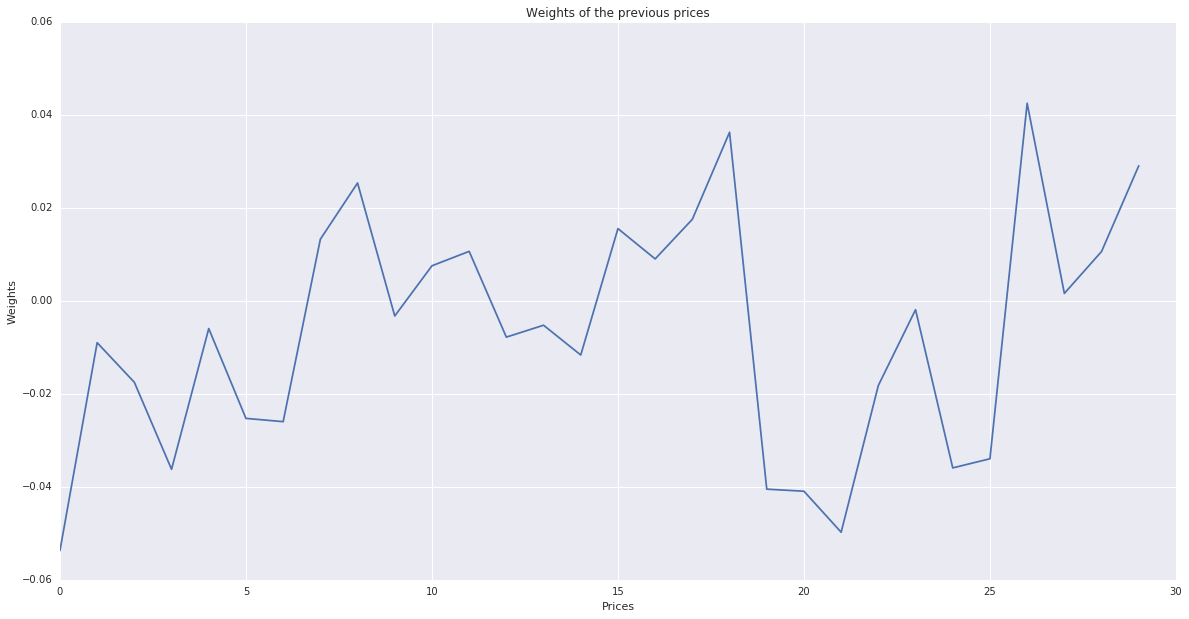

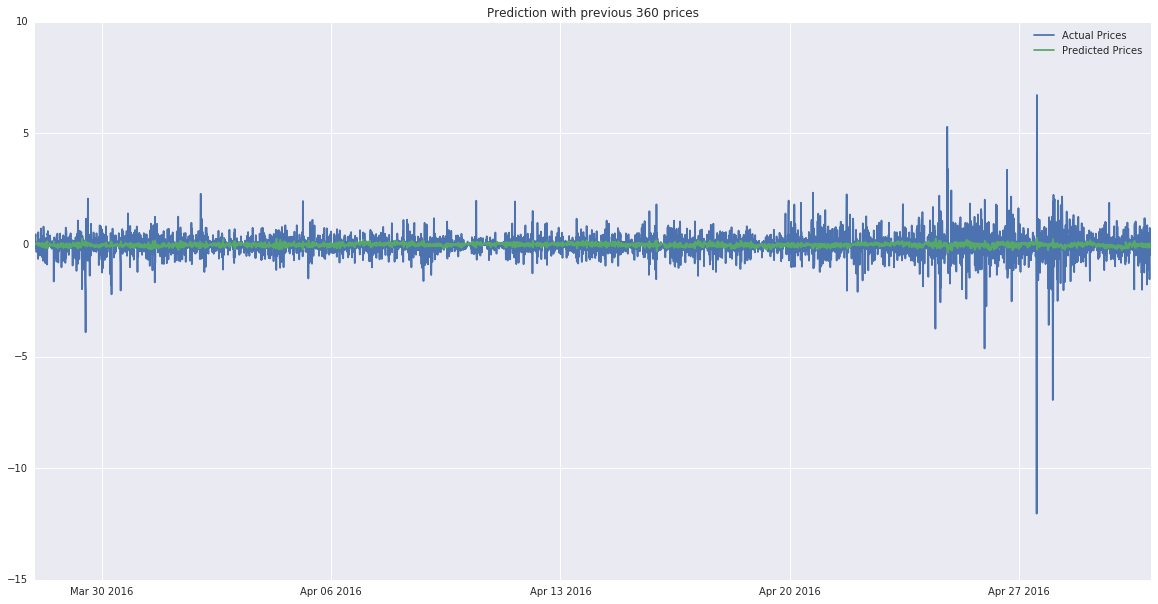

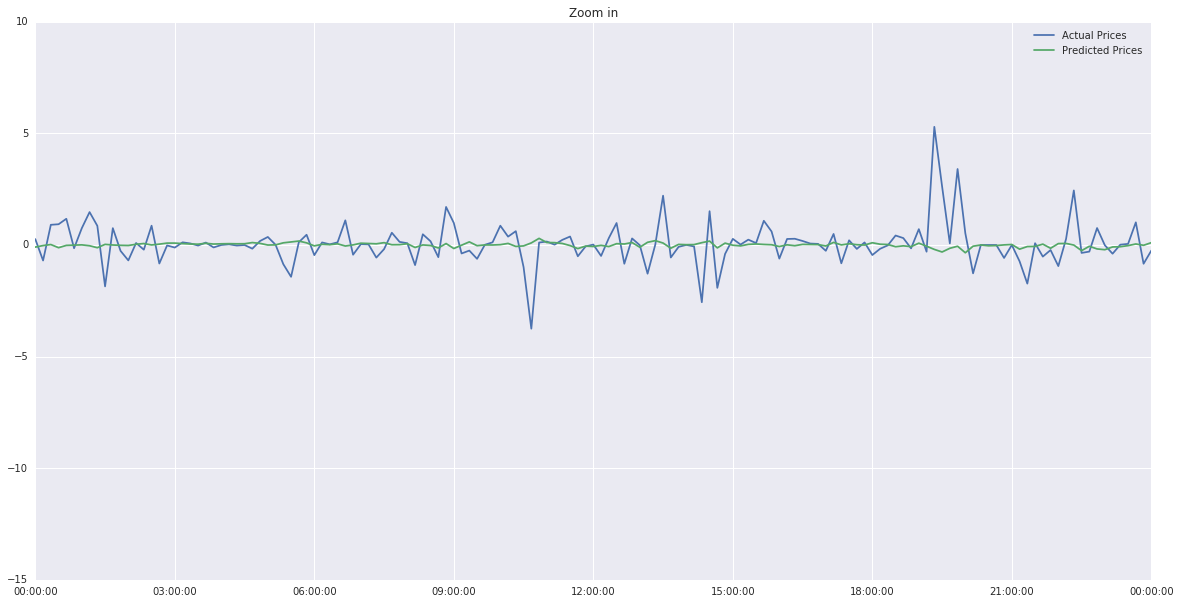

In [62]:
evaluate(datas[4].copy())